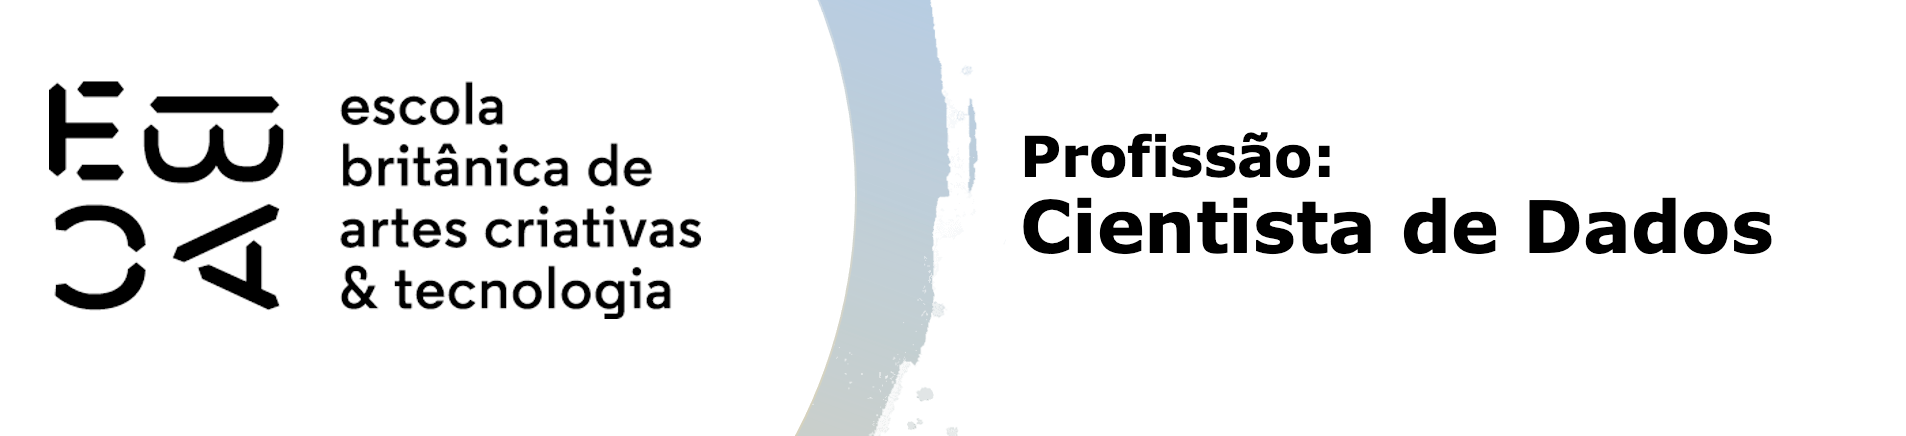

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_pickle('base_nfp.pkl')
df = df[df['Data Emissão'].dt.year >= 2020].dropna()
df.head(2)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
# variáveis temporais
df['dia_semana'] = df['Data Emissão'].dt.day_name()
df['fds'] = df['dia_semana'].isin(['Saturday', 'Sunday'])
df['dia_mes'] = df['Data Emissão'].dt.day
df['mes'] = df['Data Emissão'].dt.month_name()
df['trimestre'] = df['Data Emissão'].dt.quarter
df['ano'] = df['Data Emissão'].dt.year


In [4]:
# criando categorias de Valor NF

df['valor_nf_cat_5'] = pd.qcut(df['Valor NF'], q=5, labels=False)
df['valor_nf_cat_10'] = pd.qcut(df['Valor NF'], q=10, labels=False)
df['valor_nf_cat_20'] = pd.qcut(df['Valor NF'], q=20, labels=False)
df['valor_nf_cat_50'] = pd.qcut(df['Valor NF'], q=50, labels=False)

In [5]:
variaveis_criadas = df.iloc[:, -10:].columns
variaveis_criadas

Index(['dia_semana', 'fds', 'dia_mes', 'mes', 'trimestre', 'ano',
       'valor_nf_cat_5', 'valor_nf_cat_10', 'valor_nf_cat_20',
       'valor_nf_cat_50'],
      dtype='object')

In [6]:
df.iloc[:, -10:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dia_mes,86000.0,15.704767,8.705047,1.0,8.0,15.0,23.00,31.0
trimestre,86000.0,2.559512,1.125015,1.0,2.0,3.0,4.00,4.0
ano,86000.0,2020.516291,0.499737,2020.0,2020.0,2021.0,2021.00,2021.0
valor_nf_cat_5,86000.0,1.999919,1.414300,0.0,1.0,2.0,3.00,4.0
valor_nf_cat_10,86000.0,4.499372,2.872027,0.0,2.0,4.0,7.00,9.0
valor_nf_cat_20,86000.0,9.498895,5.766551,0.0,4.0,9.0,14.25,19.0
valor_nf_cat_50,86000.0,24.496605,14.431015,0.0,12.0,24.0,37.00,49.0


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [7]:
metadados = pd.DataFrame({
    'variavel': variaveis_criadas,
    'tipo': [df[var].dtype for var in variaveis_criadas]
})
metadados.set_index('variavel', inplace=True)

metadados['papel'] = 'covariavel'

metadados['nunique'] = [df[var].nunique() for var in variaveis_criadas]
metadados

,tipo,papel,nunique
variavel,,,
dia_semana,object,covariavel,7
fds,bool,covariavel,2
dia_mes,int32,covariavel,31
mes,object,covariavel,12
trimestre,int32,covariavel,4
ano,int32,covariavel,2
valor_nf_cat_5,int64,covariavel,5
valor_nf_cat_10,int64,covariavel,10
valor_nf_cat_20,int64,covariavel,20


In [8]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe

    iv_value = tab['iv_parcial'].sum()
    return iv_value


In [9]:
for var in metadados[metadados.papel=='covariavel'].index:
        metadados.loc[var, 'IV'] = IV(df[var], df['flag_credito'])

        
metadados

,tipo,papel,nunique,IV
variavel,,,,
dia_semana,object,covariavel,7,0.006784
fds,bool,covariavel,2,0.005311
dia_mes,int32,covariavel,31,0.012432
mes,object,covariavel,12,0.007772
trimestre,int32,covariavel,4,0.003010
ano,int32,covariavel,2,0.002589
valor_nf_cat_5,int64,covariavel,5,0.044709
valor_nf_cat_10,int64,covariavel,10,0.056499
valor_nf_cat_20,int64,covariavel,20,0.067870


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

In [10]:
faixa = {
    'inútil':0.0,
    'fraco':0.02,
    'médio':0.1,
    'forte':0.3,
    'suspeito':0.5
}

In [11]:
metadados['força'] = [
    'inútil' if metadados.loc[var, 'IV'] < faixa['fraco'] else
    'fraco' if metadados.loc[var, 'IV'] < faixa['médio'] else
    'médio' if metadados.loc[var, 'IV'] < faixa['forte'] else
    'forte' if metadados.loc[var, 'IV'] < faixa['suspeito'] else
    'suspeito'
    for var in metadados.index
]

metadados

,tipo,papel,nunique,IV,força
variavel,,,,,
dia_semana,object,covariavel,7,0.006784,inútil
fds,bool,covariavel,2,0.005311,inútil
dia_mes,int32,covariavel,31,0.012432,inútil
mes,object,covariavel,12,0.007772,inútil
trimestre,int32,covariavel,4,0.003010,inútil
ano,int32,covariavel,2,0.002589,inútil
valor_nf_cat_5,int64,covariavel,5,0.044709,fraco
valor_nf_cat_10,int64,covariavel,10,0.056499,fraco
valor_nf_cat_20,int64,covariavel,20,0.067870,fraco


**Avaliação:** Todas as variáveis testadas possuem um poder preditivo abaixo de nível médio, as variáveis categóricas possuem uma relação `proporcional ao IV`.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

| Variável | Descrição |
|----------|-----------|
| Retorno | Valor do crédito dividido pelo valor da nota |
| flag_credito | Indicadora se a nota possui crédito positivo |

- Iremos usar a variável `flag_credito` como variável resposta.

In [41]:
# Agrupando por trimestre
resumo_trimestre = df.groupby(['trimestre', 'categoria']).agg(
    quantidade=('flag_credito', 'size'),
    proporcao=('flag_credito', 'mean')
).reset_index()
resumo_trimestre

,trimestre,categoria,quantidade,proporcao
0,1,Alimentos,1282,0.708268
1,1,Auto posto,152,0.223684
2,1,Construção,3852,0.470145
3,1,Farmácia,2432,0.262336
4,1,Mercado,6727,0.486249
5,1,Restaurantes,754,0.782493
6,1,Varejo,839,0.205006
7,1,Vestuário,428,0.268692
8,1,não definido,4077,0.394162
9,2,Alimentos,1167,0.630677


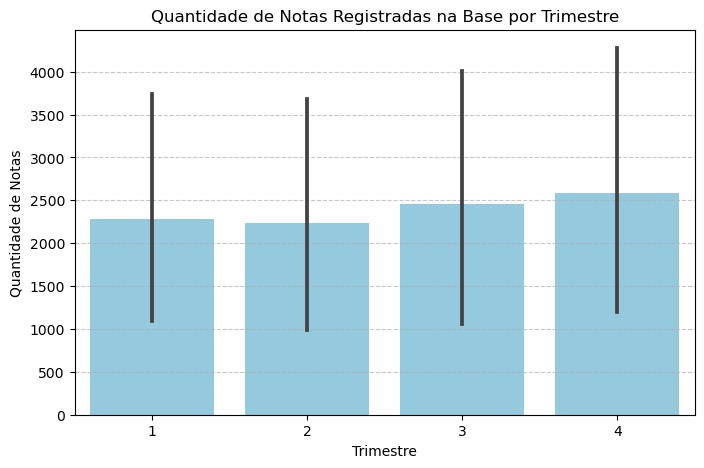

In [42]:
plt.figure(figsize=(8, 5))
sns.barplot(data=resumo_trimestre, x='trimestre', y='quantidade', color='skyblue')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.title('Quantidade de Notas Registradas na Base por Trimestre')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

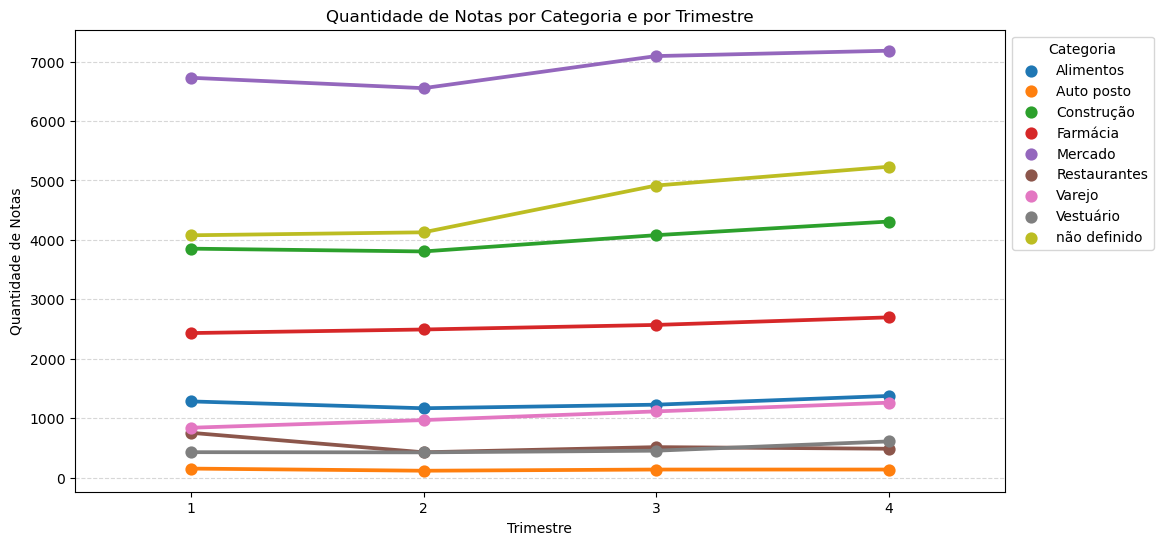

In [39]:
# Plot: quantidade de notas por categoria e por período
plt.figure(figsize=(12, 6))
sns.pointplot(data=resumo_trimestre, x='trimestre', y='quantidade', hue='categoria', markers='o')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.title('Quantidade de Notas por Categoria e por Trimestre')
plt.legend(title='Categoria', bbox_to_anchor=(1,1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

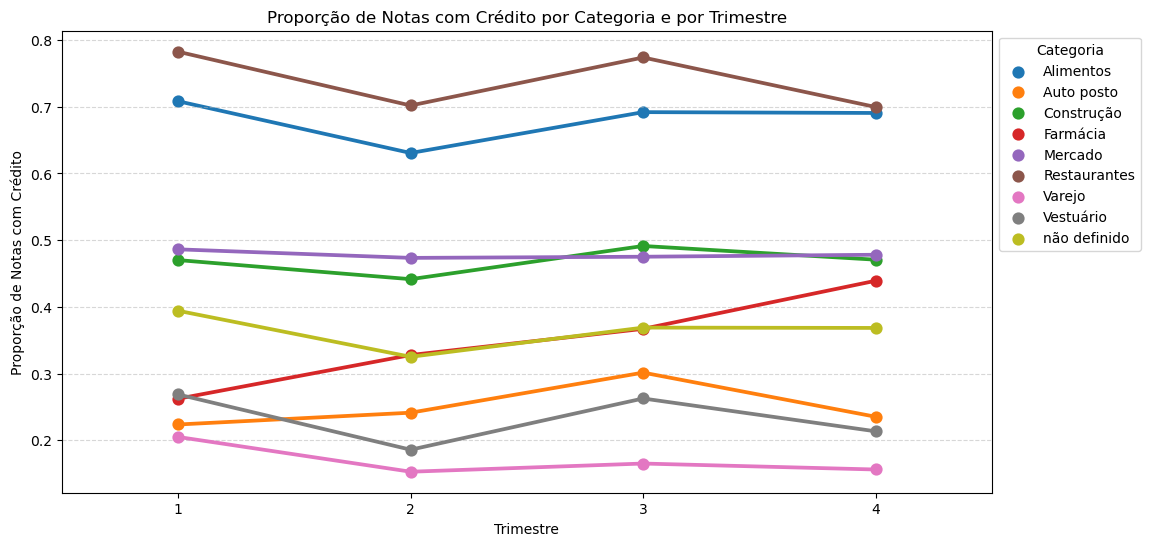

In [40]:
# Plot: proporção de notas com crédito por categoria e por período
plt.figure(figsize=(12, 6))
sns.pointplot(data=resumo_trimestre, x='trimestre', y='proporcao', hue='categoria',  markers='o')
plt.xlabel('Trimestre')
plt.ylabel('Proporção de Notas com Crédito')
plt.title('Proporção de Notas com Crédito por Categoria e por Trimestre')
plt.legend(title='Categoria', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

| Variável | Descrição |
|----------|-----------|
| Retorno | Valor do crédito dividido pelo valor da nota |
| flag_credito | Indicadora se a nota possui crédito positivo |

- Iremos usar a variável `flag_credito` como variável resposta.

In [156]:
epsilon = 1e-6

tab = pd.crosstab([df['ano'],df['trimestre'],df['mes'],df['dia_mes'],df['fds'],df['dia_semana'], df['categoria']], df['flag_credito'], margins=True, margins_name='total')
tab['pct_evento'] = (tab[tab.columns[1]] + epsilon) / (np.array(tab.loc['total', tab.columns[1]].tolist())+epsilon)
tab['pct_nao_evento'] = (tab[tab.columns[0]] + epsilon) / (np.array(tab.loc['total', tab.columns[0]].tolist())+epsilon)



tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
tab


flag_credito                                                       0      1  \
ano   trimestre mes      dia_mes fds  dia_semana categoria                    
2020  1         February 1       True Saturday   Alimentos         0      6   
                                                 Auto posto        1      0   
                                                 Construção        9     17   
                                                 Farmácia         10      1   
                                                 Mercado          14     17   
...                                                              ...    ...   
2021  4         October  31      True Sunday     Restaurantes      1      3   
                                                 Varejo            7      1   
                                                 Vestuário         2      0   
                                                 não definido      8     10   
total                                                          48682  37318   

flag_credito                                                   total  \
ano   trimestre mes      dia_mes fds  dia_semana categoria             
2020  1         February 1       True Saturday   Alimentos         6   
                                                 Auto posto        1   
                                                 Construção       26   
                                                 Farmácia         11   
                                                 Mercado          31   
...                                                              ...   
2021  4         October  31      True Sunday     Restaurantes      4   
                                                 Varejo            8   
                                                 Vestuário         2   
                                                 não definido     18   
total                                                          86000   

flag_credito                                                     pct_evento  \
ano   trimestre mes      dia_mes fds  dia_semana categoria                    
2020  1         February 1       True Saturday   Alimentos     1.607803e-04   
                                                 Auto posto    2.679672e-11   
                                                 Construção    4.555443e-04   
                                                 Farmácia      2.679675e-05   
                                                 Mercado       4.555443e-04   
...                                                                     ...   
2021  4         October  31      True Sunday     Restaurantes  8.039019e-05   
                                                 Varejo        2.679675e-05   
                                                 Vestuário     2.679672e-11   
                                                 não definido  2.679672e-04   
total                                                          1.000000e+00   

flag_credito                                                   pct_nao_evento  \
ano   trimestre mes      dia_mes fds  dia_semana categoria                      
2020  1         February 1       True Saturday   Alimentos       2.054147e-11   
                                                 Auto posto      2.054149e-05   
                                                 Construção      1.848733e-04   
                                                 Farmácia        2.054148e-04   
                                                 Mercado         2.875806e-04   
...                                                                       ...   
2021  4         October  31      True Sunday     Restaurantes    2.054149e-05   
                                                 Varejo          1.437903e-04   
                                                 Vestuário       4.108297e-05   
                                                 não definido    1.643318e-04   
total                              

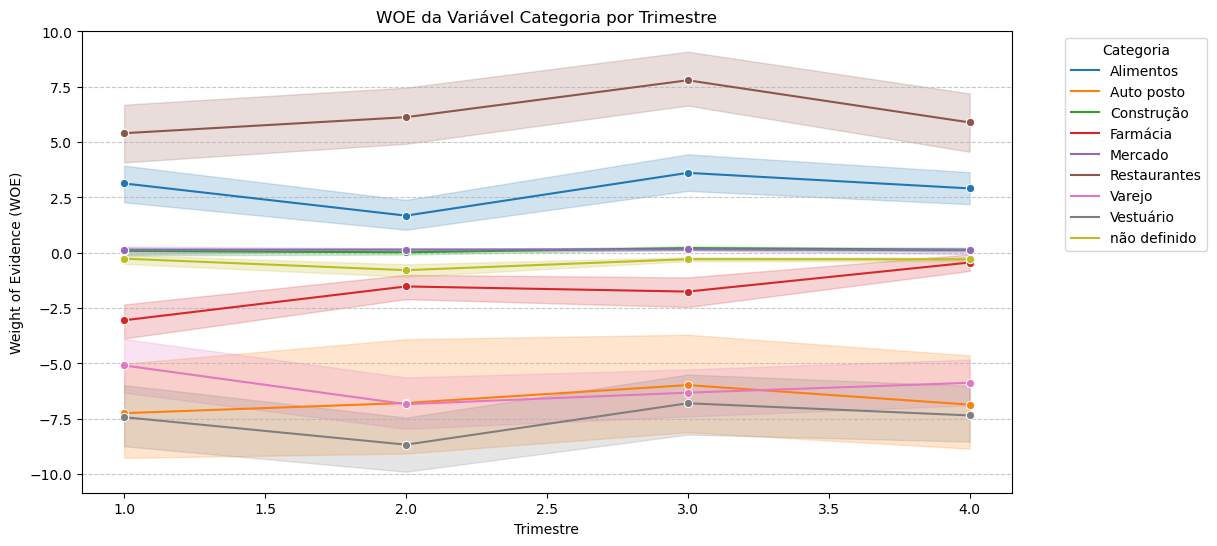

In [168]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=tab, x='trimestre', y='woe', hue='categoria', marker='o')
plt.xlabel('Trimestre')
plt.ylabel('Weight of Evidence (WOE)')
plt.title('WOE da Variável Categoria por Trimestre')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [172]:
tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
tab

flag_credito                                                       0      1  \
ano   trimestre mes      dia_mes fds  dia_semana categoria                    
2020  1         February 1       True Saturday   Alimentos         0      6   
                                                 Auto posto        1      0   
                                                 Construção        9     17   
                                                 Farmácia         10      1   
                                                 Mercado          14     17   
...                                                              ...    ...   
2021  4         October  31      True Sunday     Restaurantes      1      3   
                                                 Varejo            7      1   
                                                 Vestuário         2      0   
                                                 não definido      8     10   
total                                                          48682  37318   

flag_credito                                                   total  \
ano   trimestre mes      dia_mes fds  dia_semana categoria             
2020  1         February 1       True Saturday   Alimentos         6   
                                                 Auto posto        1   
                                                 Construção       26   
                                                 Farmácia         11   
                                                 Mercado          31   
...                                                              ...   
2021  4         October  31      True Sunday     Restaurantes      4   
                                                 Varejo            8   
                                                 Vestuário         2   
                                                 não definido     18   
total                                                          86000   

flag_credito                                                     pct_evento  \
ano   trimestre mes      dia_mes fds  dia_semana categoria                    
2020  1         February 1       True Saturday   Alimentos     1.607803e-04   
                                                 Auto posto    2.679672e-11   
                                                 Construção    4.555443e-04   
                                                 Farmácia      2.679675e-05   
                                                 Mercado       4.555443e-04   
...                                                                     ...   
2021  4         October  31      True Sunday     Restaurantes  8.039019e-05   
                                                 Varejo        2.679675e-05   
                                                 Vestuário     2.679672e-11   
                                                 não definido  2.679672e-04   
total                                                          1.000000e+00   

flag_credito                                                   pct_nao_evento  \
ano   trimestre mes      dia_mes fds  dia_semana categoria                      
2020  1         February 1       True Saturday   Alimentos       2.054147e-11   
                                                 Auto posto      2.054149e-05   
                                                 Construção      1.848733e-04   
                                                 Farmácia        2.054148e-04   
                                                 Mercado         2.875806e-04   
...                                                                       ...   
2021  4         October  31      True Sunday     Restaurantes    2.054149e-05   
                                                 Varejo          1.437903e-04   
                                                 Vestuário       4.108297e-05   
                                                 não definido    1.643318e-04   
total                              

trimestre
1    0.550679
2    0.475724
3    0.521071
4    0.474011
Name: iv_parcial, dtype: float64

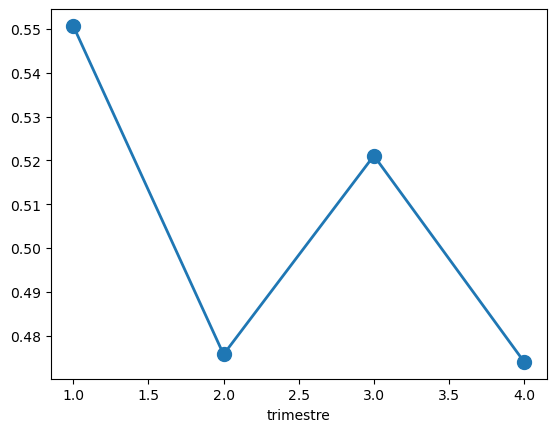

In [185]:
# Calculando a soma de iv_parcial por trimestre
iv_por_trimestre = tab.groupby('trimestre')['iv_parcial'].sum().reindex([1,2,3,4])
iv_por_trimestre.plot(kind='line', marker='o', linewidth=2, markersize=10)
iv_por_trimestre

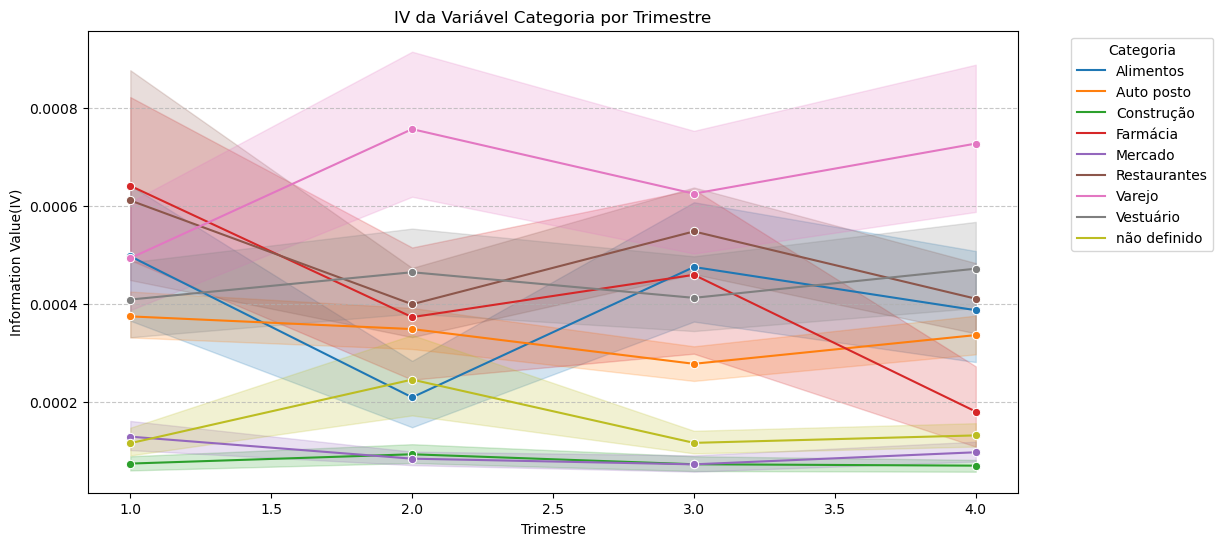

In [169]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=tab, x='trimestre', y='iv_parcial', hue='categoria', marker='o')
plt.xlabel('Trimestre')
plt.ylabel('Information Value(IV)')
plt.title('IV da Variável Categoria por Trimestre')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
    
    - <font color='red'>**Resposta:** Alimentos e Restaurantes</font>
- Essas diferenças são estáveis no tempo?
    
    - *<font color='red'>**Resposta:** Não, há uma variação nas análises de IV e WOE, onde há cruzamento na média desses indicadores com outras variáveis, o que pode ser visualizado graficamente.</font>

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.